In [31]:
import numpy as np
from numpy import sin, cos, tan, atan, cosh, sinh, tanh, abs, linspace, argmin, argmax, pi, mean, exp, sqrt, zeros, ones, nan
import scipy
import matplotlib.pyplot as plt
from scipy.special import roots_legendre, eval_legendre
from numpy.polynomial import chebyshev

In [ ]:
class merged_sol:
    def __init__(self, sol1, sol2):
        self.sol1 = sol1
        self.sol2 = sol2
        assert(abs(sol1.t[-1] - sol2.t[0]) < 1e-9)

        self.start = sol1.t[0]
        self.boundary = sol1.t[-1]

    
    def __call__(self, x, *args, **kwds):
        x = np.array(x)

        condition = (self.start < x and x < self.boundary) or (self.start > x and x > self.boundary)

        return np.where(condition, self.sol1(x), self.sol2(x))

        

In [35]:
class PerturbationCSWESolution(): pass

class PCSWE():

    def __init__(self):
        self.debug = False


        # geometry
        self.A = 0.72
        self.H = 7.12 
        self.L = 8e3

        # tunable
        self.r = 0.24
        self.h0 = 0.0025
        self.small_number = nan
        self.bc = nan
        # self.bc = self.bc_moving_boundary


        # morphodynamics
        self.p = 0.4 # porosity
        self.c_d = 0.0025
        self.lmbda = 6.8e-6
        self.d50 = 0.13e-3

        # universal constants
        self.g = 9.81
        self.sigma = 1.4e-4
        self.rho_w = 1025
        self.rho_s = 2650

        self.set_derivative_vars()
        
    def set_derivative_vars(self):
        self.epsilon = self.A / self.H
        self.eta = self.sigma * self.L / sqrt(self.g * self.H)
        self.U = self.epsilon * self.sigma * self.L
        self.kappa = self.g * self.H / (self.sigma * self.L) ** 2

        self.s = self.rho_s / self.rho_w

        self.delta = 0.04 * self.c_d**(3/2) * self.A * (self.sigma * self.L)**4 / \
                    (self.g**2 * (self.s-1)**2 * self.d50 * self.H**6 * (1-self.p))

    def h_fx(self, x): return x
    def h_fx_dx(self, x): return 1 * np.ones(np.array(x).shape)
    def h_fx_dxx(self, x): return 0
    def h_fx_dxxx(self, x): return 0
    
    def deriv_LO(self, x_x, y0_x):
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)
        u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
        u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_LO_hop(self, x_x, y0_x):
        assert(x_x > 0.9)
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        h_x, h_x_dx, h_x_dxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)
        dz0c_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0c_x - u0s_x)
        dz0s_x_dx = 1 / self.kappa * ( - self.r / (1 - h_x + self.h0) * u0s_x + u0c_x)
        u0c_x_dx =  ( dz0s_x_dx - u0c_x * h_x_dxx)  / (2*h_x_dx)
        u0s_x_dx =  (-dz0c_x_dx - u0s_x * h_x_dxx)  / (2*h_x_dx)
        return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])
    
    def deriv_FO(self, x_x, y1_x, y0_x, y0_x_dx):
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx= self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x)
        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x) - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x) - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x) - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa
        u1r_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1r_x              - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x + dz0s_x * u0s_x_dx + dz0s_x_dx * u0s_x))
        u1c_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1c_x - 2 * dz1s_x - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x - dz0s_x * u0s_x_dx - dz0s_x_dx * u0s_x))
        u1s_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1s_x + 2 * dz1c_x - 1 / 2 * (dz0s_x * u0c_x_dx + dz0s_x_dx * u0c_x + dz0c_x * u0s_x_dx + dz0c_x_dx * u0s_x))
        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx]) 

    def deriv_FO_hop(self, x_x, y1_x, y0_x, y0_x_dx):
        assert(x_x > 0.9)
        dz0c_x, dz0s_x, u0c_x, u0s_x = y0_x
        dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx = y0_x_dx
        dz1r_x, dz1c_x, dz1s_x, u1r_x, u1c_x, u1s_x = y1_x
        h_x, h_x_dx, h_x_dxx, h_x_dxxx = self.h_fx(x_x), self.h_fx_dx(x_x), self.h_fx_dxx(x_x), self.h_fx_dxxx(x_x)

        dz1r_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1r_x - 0.5 * (  dz0c_x *  u0s_x - dz0s_x *  u0c_x) - 0.5 * (  dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx + u0s_x * u0s_x_dx)            ) / self.kappa
        dz1c_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1c_x - 0.5 * (  dz0c_x *  u0s_x + dz0s_x *  u0c_x) - 0.5 * (- dz0s_x * dz0s_x_dx + dz0c_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0c_x_dx - u0s_x * u0s_x_dx) - 2 * u1s_x) / self.kappa
        dz1s_x_dx = (1 / (1 - h_x + self.h0) * (- self.r * u1s_x + 0.5 * (  dz0c_x *  u0c_x - dz0s_x *  u0s_x) - 0.5 * (  dz0c_x * dz0s_x_dx + dz0s_x * dz0c_x_dx) * self.kappa) - 0.5 * (u0c_x * u0s_x_dx + u0s_x * u0c_x_dx) + 2 * u1c_x) / self.kappa
        
        # second derivatives of leading order components:
        dz0c_x_dxx = 1 / self.kappa * (- self.r / (1 - h_x + self.h0)**2 * h_x_dx * u0c_x - self.r / (1 - h_x + self.h0) * u0c_x_dx - u0s_x_dx)
        dz0s_x_dxx = 1 / self.kappa * (- self.r / (1 - h_x + self.h0)**2 * h_x_dx * u0s_x - self.r / (1 - h_x + self.h0) * u0s_x_dx + u0c_x_dx)
        u0c_x_dxx = 1/3 * (- h_x_dxx / h_x_dx**2 * ( dz0s_x_dx - u0c_x * h_x_dxx) + 1 / h_x_dx * ( dz0s_x_dxx - u0c_x_dx * h_x_dxx - u0c_x * h_x_dxxx))
        u0s_x_dxx = 1/3 * (- h_x_dxx / h_x_dx**2 * (-dz0c_x_dx - u0s_x * h_x_dxx) + 1 / h_x_dx * (-dz0c_x_dxx - u0s_x_dx * h_x_dxx - u0s_x * h_x_dxxx))

        # second derivatives of products of leading order components:
        dz_u_cc_x_dxx = (dz0c_x * u0c_x_dxx + 2 * dz0c_x_dx * u0c_x_dx + dz0c_x_dxx * u0c_x)
        dz_u_ss_x_dxx = (dz0s_x * u0s_x_dxx + 2 * dz0s_x_dx * u0s_x_dx + dz0s_x_dxx * u0s_x)
        dz_u_cs_x_dxx = (dz0s_x * u0c_x_dxx + 2 * dz0s_x_dx * u0c_x_dx + dz0s_x_dxx * u0c_x)
        dz_u_sc_x_dxx = (dz0c_x * u0s_x_dxx + 2 * dz0c_x_dx * u0s_x_dx + dz0c_x_dxx * u0s_x)

        # l'hopital
        u1r_x_dx = (             - u1r_x * h_x_dxx + (dz_u_cc_x_dxx + dz_u_ss_x_dxx) / 2) / (2*h_x_dx)
        u1c_x_dx = ( 2*dz1s_x_dx - u1c_x * h_x_dxx + (dz_u_cc_x_dxx - dz_u_ss_x_dxx) / 2) / (2*h_x_dx)
        u1s_x_dx = (-2*dz1c_x_dx - u1s_x * h_x_dxx + (dz_u_cs_x_dxx + dz_u_sc_x_dxx) / 2) / (2*h_x_dx)
        return np.array([dz1r_x_dx, dz1c_x_dx, dz1s_x_dx, u1r_x_dx, u1c_x_dx, u1s_x_dx]) 
   
    def deriv(self, x_x, y_x):
        y0_x, y1_x = np.split(y_x, [4], axis=0)
        y0_x_dx = self.deriv_LO(x_x, y0_x)
        y1_x_dx = self.deriv_FO(x_x, y1_x, y0_x, y0_x_dx)
        y_x_dx = np.concatenate((y0_x_dx, y1_x_dx), axis=0)
        return y_x_dx
    
    def deriv_hop(self, x_x, y_x):
        y0_x, y1_x = np.split(y_x, [4], axis=0)
        y0_x_dx = self.deriv_LO_hop(x_x, y0_x)
        y1_x_dx = self.deriv_FO_hop(x_x, y1_x, y0_x, y0_x_dx)
        y_x_dx = np.concatenate((y0_x_dx, y1_x_dx), axis=0)
        return y_x_dx
    

    def y_for_initial_dz(self, dz_r):
        dz0c_r, dz0s_r, dz1r_r, dz1c_r, dz1s_r = dz_r
        h_r, h_r_dx, h_r_dxx = self.h_fx(1), self.h_fx_dx(1), self.h_fx_dxx(1)
        u0c_r = dz0s_r / h_r_dx
        u0s_r = -dz0c_r / h_r_dx
        dz0c_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0c_r - u0s_r)
        dz0s_r_dx = 1 / self.kappa * ( - self.r / (1 - h_r + self.h0) * u0s_r + u0c_r)
        u0c_r_dx =  ( dz0s_r_dx - u0c_r * h_r_dxx)  / (2*h_r_dx)
        u0s_r_dx =  (-dz0c_r_dx - u0s_r * h_r_dxx)  / (2*h_r_dx)
        u1r_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r + dz0s_r * u0s_r_dx + dz0s_r_dx * u0s_r))
        u1c_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0c_r_dx + dz0c_r_dx * u0c_r - dz0s_r * u0s_r_dx - dz0s_r_dx * u0s_r) - 2 * dz1s_r)
        u1s_r = 1 / h_r_dx * (1 / 2 * (dz0c_r * u0s_r_dx + dz0c_r_dx * u0s_r + dz0s_r * u0c_r_dx + dz0s_r_dx * u0c_r) + 2 * dz1c_r)
        y_r = dz0c_r, dz0s_r, u0c_r, u0s_r, dz1r_r, dz1c_r, dz1s_r, u1r_r, u1c_r, u1s_r
        return y_r

    def ivp(self, dz_r, dense_output=False):
        y_r = self.y_for_initial_dz(dz_r)

        x_boundary = 1 - 1e-2

        x_range = [1, x_boundary]
        sol1 = scipy.integrate.solve_ivp(
            self.deriv_hop,
            x_range,
            y_r,
            rtol=1e-7,
            atol=1e-7,
            method='RK45',
            dense_output=dense_output
        )

        y_boundary = sol1.y[:, -1]

        x_range = [x_boundary, 0]
        sol2 = scipy.integrate.solve_ivp(
            self.deriv,
            x_range,
            y_boundary,
            rtol=1e-7,
            atol=1e-7,
            method='RK45',
            dense_output=dense_output
        )
        

        if dense_output:
            return sol1, sol2
        
        return sol2


    def solve_shooting(self):
        
        def mismatch(u_r):
            sol = self.ivp(u_r)

            dz0c_l, dz0s_l, u0c_l, u0s_l, dz1r_l, dz1c_l, dz1s_l, u1r_l, u1c_l, u1s_l = sol.y[:, -1]
            return [dz0c_l - 1, dz0s_l, dz1r_l, dz1c_l, dz1s_l]


        dz_guess = 0.001 * np.ones((5))
        res = scipy.optimize.root(mismatch, dz_guess)
        print(res)
        if res.status == 1:
            sol1, sol2 = self.ivp(res.x, dense_output=True)
            return res, sol1, sol2
      


 message: The solution converged.
 success: True
  status: 1
     fun: [-3.331e-16  1.301e-18  1.797e-17  3.065e-13 -1.061e-15]
       x: [ 1.018e+00  1.987e-02  2.007e-04  1.311e-03 -3.713e-02]
  method: hybr
    nfev: 14
    fjac: [[-9.982e-01  1.949e-02 ...  3.059e-04 -5.723e-02]
           [-1.946e-02 -9.998e-01 ...  7.502e-05 -9.930e-04]
           ...
           [-1.977e-03 -6.544e-05 ... -9.996e-01  2.911e-02]
           [ 5.721e-02 -1.246e-04 ... -2.918e-02 -9.979e-01]]
       r: [-9.838e-01 -5.582e-05 ... -6.191e-05 -9.358e-01]
     qtf: [ 9.918e-13 -4.385e-12 -7.711e-14 -5.777e-11  1.313e-11]
(10, 2)
(10, 18)


C:\Users\jolieken\AppData\Local\Temp\ipykernel_42580\6640909.py:57: RuntimeWarning: invalid value encountered in scalar divide
  u0c_x_dx = (-dz0s_x + u0c_x * h_x_dx)  / (1 - h_x)
C:\Users\jolieken\AppData\Local\Temp\ipykernel_42580\6640909.py:58: RuntimeWarning: invalid value encountered in scalar divide
  u0s_x_dx = ( dz0c_x + u0s_x * h_x_dx)  / (1 - h_x)
C:\Users\jolieken\AppData\Local\Temp\ipykernel_42580\6640909.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  u1r_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1r_x              - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x + dz0s_x * u0s_x_dx + dz0s_x_dx * u0s_x))
C:\Users\jolieken\AppData\Local\Temp\ipykernel_42580\6640909.py:80: RuntimeWarning: divide by zero encountered in scalar divide
  u1c_x_dx = 1 / (1 - h_x + self.small_number) * (h_x_dx * u1c_x - 2 * dz1s_x - 1 / 2 * (dz0c_x * u0c_x_dx + dz0c_x_dx * u0c_x - dz0s_x * u0s_x_dx - dz0s_x_dx * u0s_x))
C:\Users\jolieken\AppData\Local\Temp\ipykernel

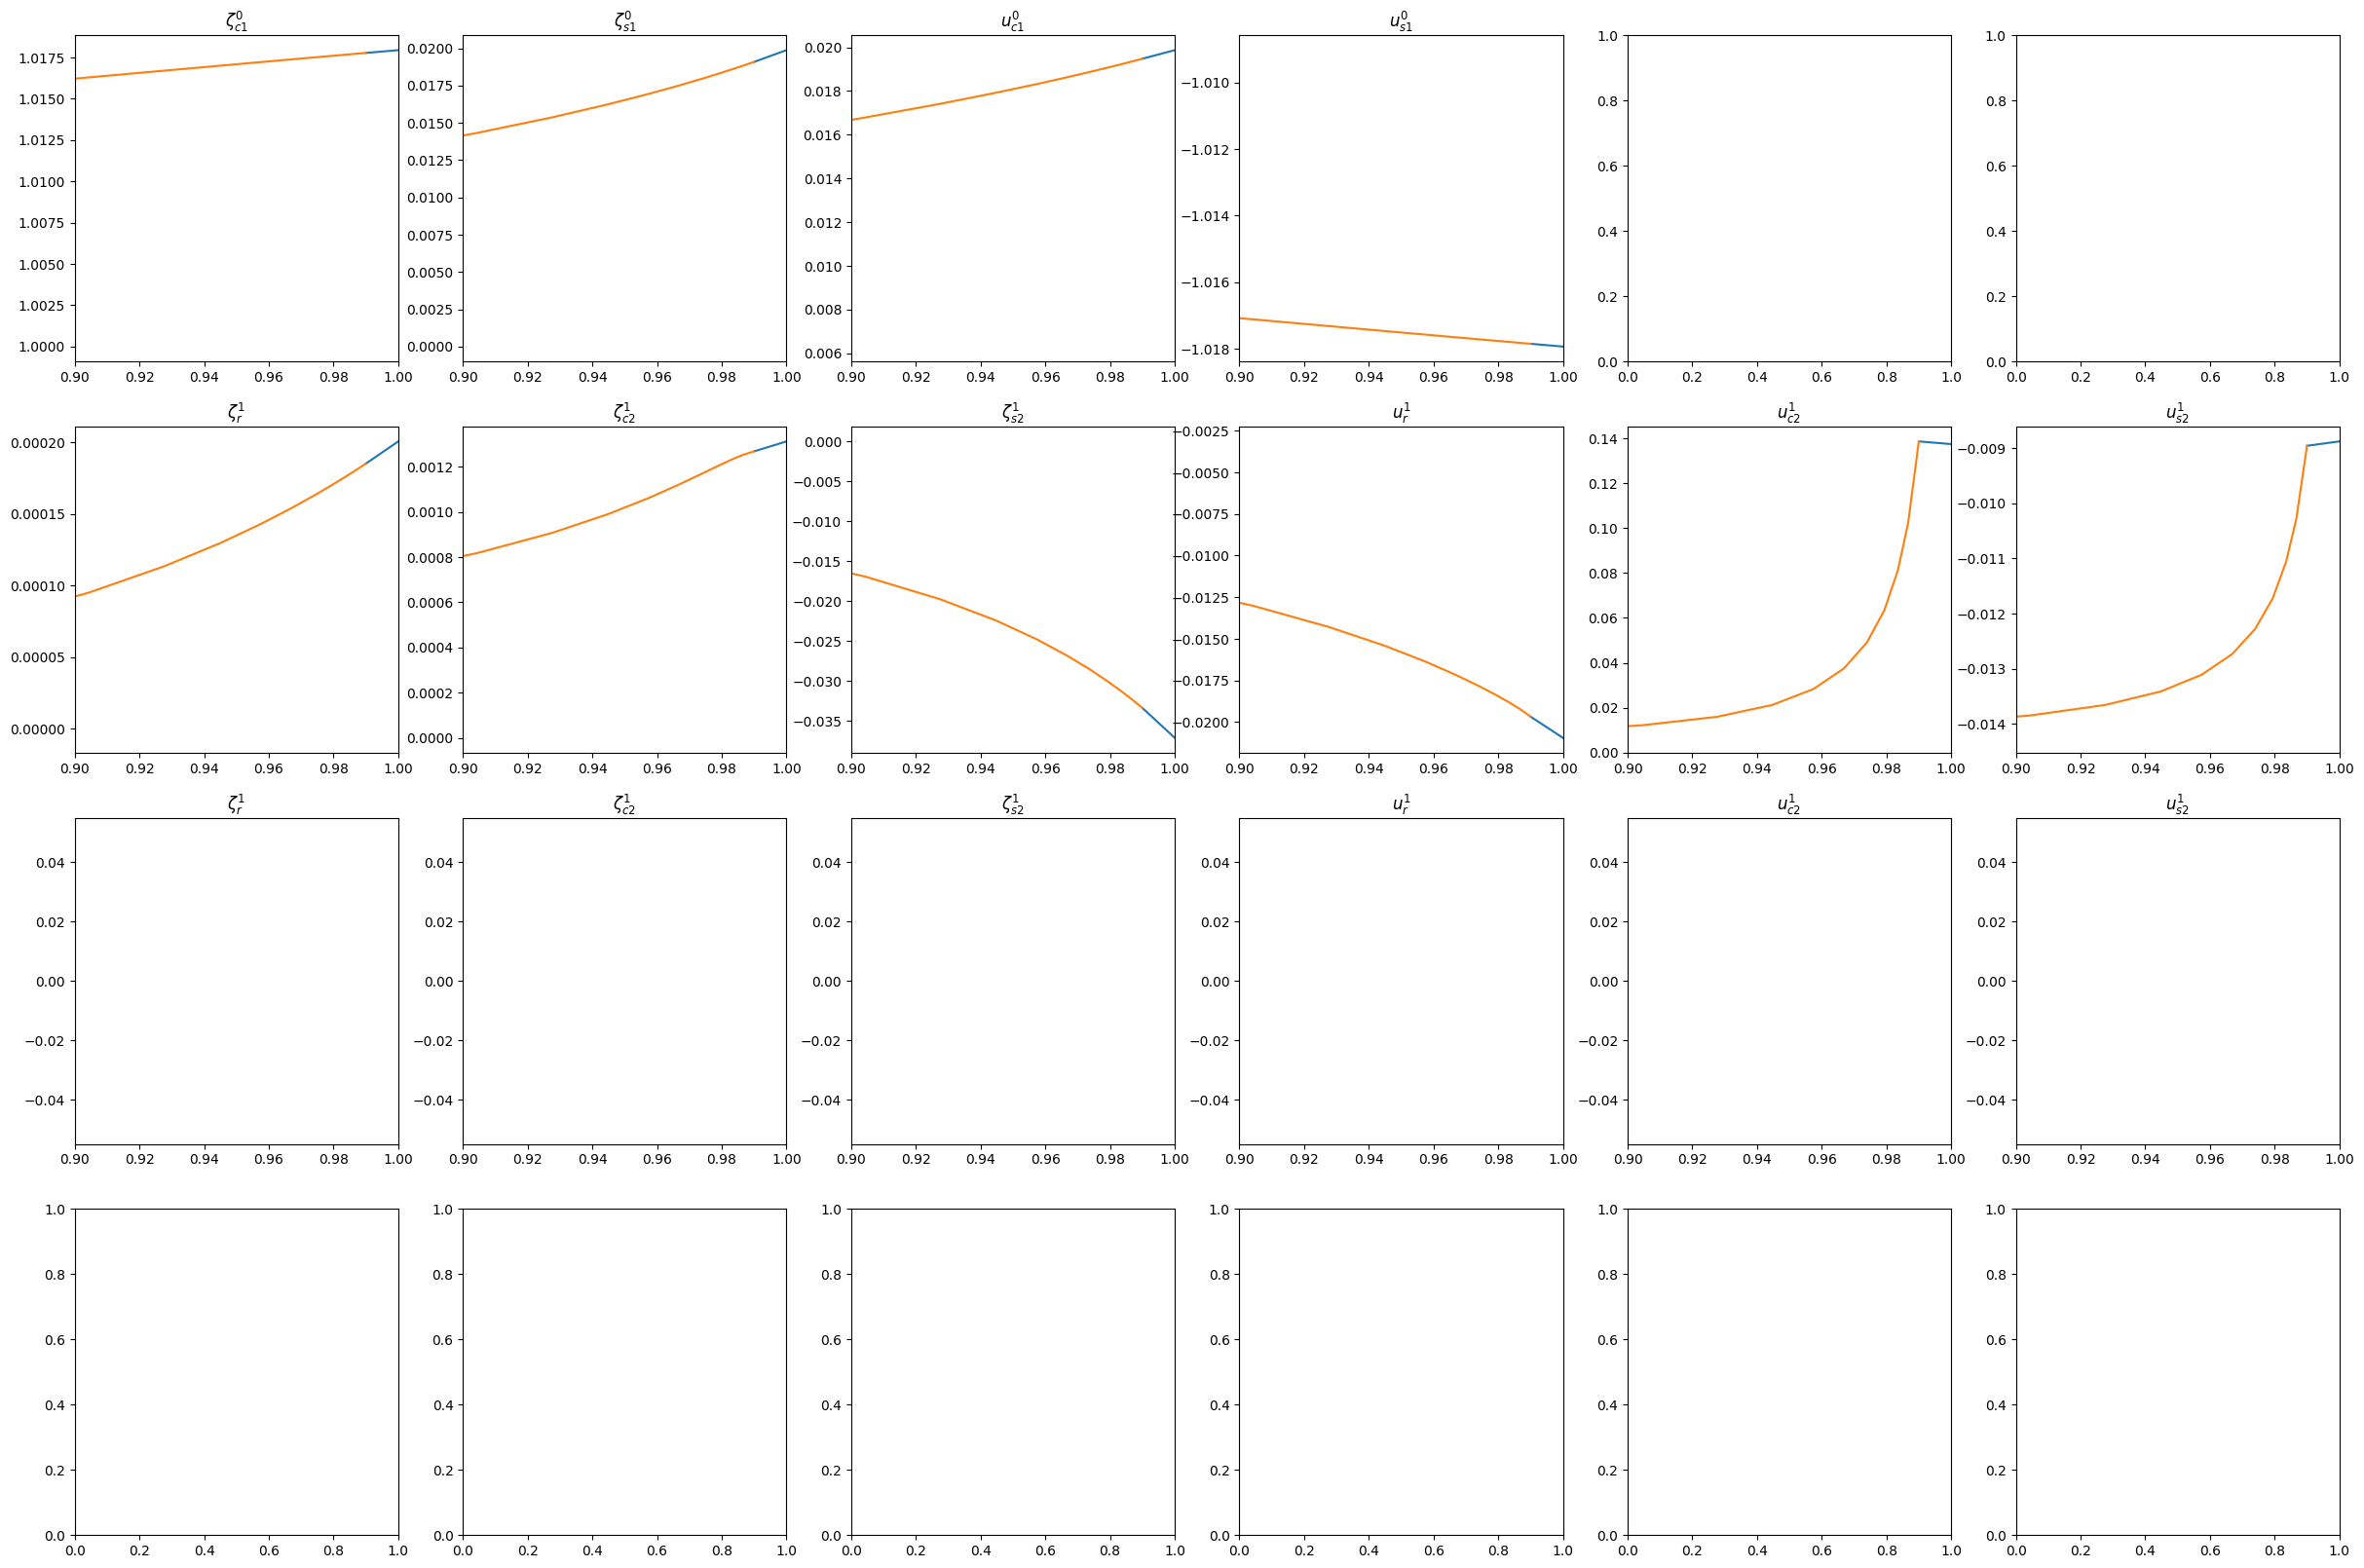

In [ ]:
pcswe = PCSWE()
pcswe.h0 = 0.1
pcswe.r = 0.45
pcswe.small_number = 0
pcswe.tol = 1e-5
pcswe.set_derivative_vars()
res, sol1, sol2 = pcswe.solve_shooting()

fig, axs = plt.subplots(4, 6, figsize=(30, 20))
labels=[r"$\zeta^0_{c1}$", r"$\zeta^0_{s1}$", r"$u^0_{c1}$", r"$u^0_{s1}$", r"$\zeta^1_{r}$", r"$\zeta^1_{c2}$", r"$\zeta^1_{s2}$", r"$u^1_{r}$", r"$u^1_{c2}$", r"$u^1_{s2}$"]



x_sol1, y_sol1 = sol1.t, sol1.y
y_sol1_dx = np.array([pcswe.deriv(x_, y_) for x_, y_ in zip(x_sol1, y_sol1.T)]).T
# u1_x_dx1 = np.array([pcswe.lhopital_FO(x_, y_[4:], y_[:4], y_dx[:4], y_dx[4:7]) for x_, y_, y_dx in zip(x_sol1, y_sol1.T, y_sol1_dx.T)]).T

# x_sol2, y_sol2 = sol2.t, sol2.y
# y_sol2_dx = np.array([pcswe.deriv(x_, y_) for x_, y_ in zip(x_sol2, y_sol2.T)]).T
# u2_x_dx2 = np.array([pcswe.lhopital_FO(x_, y_[4:], y_[:4], y_dx[:4], y_dx[4:7]) for x_, y_, y_dx in zip(x_sol2, y_sol2.T, y_sol2_dx.T)]).T



print(sol1.y.shape)
print(sol2.y.shape)

left, right = 0.9, 1
for i in range(4):
    axs[0, i].set_title(labels[i])
    axs[0, i].plot(sol1.t, sol1.y[i],'-')
    axs[0, i].plot(sol2.t, sol2.y[i],'-')

    axs[0, i].set_xlim(left, right)
for i in range(6):
    axs[1, i].set_title(labels[4+i])
    axs[1, i].plot(sol1.t, sol1.y[4+i], '-')
    axs[1, i].plot(sol2.t, sol2.y[4+i],'-')

    axs[1, i].set_xlim(left, right)

test = np.array([pcswe.deriv_hop(a, b) for a,b in zip(sol1.t, sol1.y.T)]).T
test2 = test[4+i]
for i in range(6):
    axs[2, i].set_title(labels[4+i])
    axs[2, i].plot()
    axs[2, i].plot(pcswe.deriv_FO(sol2.t, sol2.y, sol2.y[])[4+i],'-')
    axs[2, i].set_xlim(left, right)

plt.show()